<div style="display: flex; align-items: center; justify-content: space-between; background-color: #1e355f; padding: 30px;">
    <div>
        <h1 style="color: white; text-align: center; font-weight: bold;">Datos No Estructurados: IMAGEN</h1>
        <h2 style="color: white; text-align: center;">Clasificador de Melanoma</h2>
    </div>

</div>

<div style="padding: 5px;">
    <h3 style="color: #1e355f; font-weight: bold;">Realizado por:</h3>
</div>

- Álvaro Ezquerro Pérez
- María Calvo de Mora Román
- Celia Quiles Alemañ


In [9]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import pickle
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Own modules
notebook_path = os.getcwd()
if notebook_path not in sys.path:
    sys.path.append(notebook_path)
project_path = os.path.dirname(notebook_path)
if project_path not in sys.path:
    sys.path.append(project_path)
from utils.helpers import *

<div style="display: flex; align-items: center; justify-content: space-between; background-color: #1e355f; padding: 10px;">
    <div>
        <h1 style="color: white; text-align: center; font-weight: bold;">Modelo Base</h1>
    </div>
</div>


<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Descripción y Objetivos:</h2>
</div>

En este primer notebook, nuestro objetivo es implementar un modelo base empleando una arquitectura básica de Red Neuronal Convolucional (CNN) creada desde cero y sin ningún tipo de regularización, que actúa como nuestro modelo base de referencia sobre el que realizar mejoras.

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Introducción:</h2>
</div>

Una Red Neuronal Convolucional (CNN, por sus siglas en inglés) es un tipo de red neuronal profunda que se emplea principalmente para el reconocimiento y clasificación de imágenes. Se compone de dos partes principales: 
- Una sección de extracción de características, correspondiente a a la red convolucional propiamente dicha.
- Un clasificador, el cual es una red neuronal densa completamente conectada (DNN, por sus siglas en inglés).

Los elementos fundamentales de una CNN son las capas convolucionales, que incluyen una serie de filtros (también conocidos como kernels) que extraen características de las imágenes de entrada. Cada filtro comienza en una posición determinada de la imagen y se desplaza sobre ella en pasos predeterminados (conocidos como stride), calculando la convolución entre sus pesos (que se ajustan durante el proceso de entrenamiento mediante la retropropagación) y la sección de la imagen que cubre. El ajuste de los pesos de cada filtro implica la minimización de una función de pérdida (típicamente la pérdida de entropía cruzada) entre la predicción y las etiquetas verdaderas del conjunto de datos original. Para ello, se utiliza un algoritmo de optimización que actualiza el valor de los pesos. Algunos algoritmos de optimización populares incluyen Adam (que utilizaremos para nuestro problema), el descenso de gradiente estocástico (SGD) o RMSprop.

Así, la salida de cada filtro será un mapa de características, que luego pasa por una capa de agrupación (pooling) que reduce dimensionalmente la salida antes de entrar en la siguiente capa convolucional para una extracción de características más profunda.

Las primeras capas de una CNN suelen ser superficiales, lo que significa que están compuestas por menos filtros de mayor tamaño. Las características que se extraen en estas capas tienden a ser más generales, detectando bordes o la forma general de la imagen. A medida que avanzamos en la red, la cantidad de filtros aumenta (es decir, las capas se vuelven más profundas) y las características extraídas se vuelven cada vez más complejas, refiriéndose a detalles muy específicos y minuciosos de la imagen que a menudo son ininterpretables para los humanos.

Una vez que la imagen ha sido procesada a través de la parte convolucional de la red, la salida se aplana y se transfiere al clasificador (DNN). En esta parte de la arquitectura, cada neurona calcula una suma ponderada de las características de entrada y aplica una función de activación no lineal (típicamente ReLU) para producir la salida. La capa final se utiliza entonces para clasificar la imagen, empleando una neurona para cada una de las clases del problema de entrada. En esta capa, la función de activación es sigmoide (para clasificación binaria) o softmax (para problemas de múltiples clases).

De manera esquemática y con el objetivo de proporcionar una visión general de la arquitectura anteriormente descrita, la *Figura 1* muestra la arquitectura de una CNN:

<div style="text-align: center;"> 
    <img src="..\..\imgs\CNN_arquitecture.png" width="500" height="300">
    <p style="font-style: italic;">Arquitectura CNN</p>
    <p style="font-size: small;">Fuente: <a href="https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53">Saha, S. (Dic 15,2018). A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way. Towards Data Science. Recuperado de [https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53]</a></p>
</div>


<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Preparación y carga de datos:</h2>
</div>

Los datos empleados para este proyecto se obtienen del dataset disponible en [Kaggle](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data), que ha sido personalizado para construir modelos de Deep Learning que puedan clasificar esta condición médica diferenciando entre tumor maligno y benigno.

Los datos descargados de [Kaggle](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data) se ubican en el directorio `data` con la jerarquía de carpetas necesarias,la . Así, dentro del directorio `data` existen dos directorios separados `train` y `test`  que continen un número balanceado de imágenes  para cada una de las dos clases de tumor: benigno y maligno. Específicamente, se tiene que:
- El directorio `train` cuenta con dos subcarpetas, 1 para cada clase (`benign` y `malignant`) con un total de 5.000 imágenes para cada una de dichas categorías.
- El directorio `test`, cuenta de igual modo con dos subdirectorios `benign` y `malignant` con un total de 500 imágenes cada uno, suponiendo así un 10% de las imágenes del train.

Para reafirmar esto, vamos a ver cuántas imágenes hay para cada clase en el dataset de entrenamiento y prueba:

In [4]:
# Carpeta base
base_dir = "../../data"
# Carpeta de entrenamiento
train_dir = os.path.join(base_dir, "train")
# Carpeta de test
test_dir = os.path.join(base_dir, "test")

# Obtén la información de cada conjunto
num_classes_train, images_train = get_num_classes_images(train_dir)
num_classes_test, images_test = get_num_classes_images(test_dir)

In [3]:
# Crear DataFrame
data = {
    "Train": [images_train.get(cls, 0) for cls in images_train],
    "Test": [images_test.get(cls, 0) for cls in images_train]
}
df = pd.DataFrame(data, index=images_train.keys())

# Mostrar información general de clases
print(f"Number of classes: {num_classes_train}")
print(f"Existing classes: {list(images_train.keys())}\n")

print("----------------------------------------")
print("Number of images per class and dataset:")
print("----------------------------------------")
print(df)

Number of classes: 2
Existing classes: ['benign', 'malignant']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
           Train  Test
benign      4605   500
malignant   4605   500


Como se puede observar, nuestro dataset splitteado en train y test contiene las clases bien balanceados, y además, tenemos una buena cantidad de datos para el entrenamiento y la validación.

Con el objetivo de hacer unos modelos reproducibles, consideramos importante crear un directorio para almacenar los modelos entrenados. Al ser este nuestro primer modelo from scratch, es importante mencionar que este paso solo será necesario en este primer notebook, pues una vez creado este directorio, el resto de notebooks guardarán en él sus modelos, siendo común para el resto del proyecto.

In [4]:
# Creamos un directorio para almacenar los modelos entrenados
models_dir = "../../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Preprocesamiento de los datos:</h2>
</div>

Una vez caragados los datos a utilizar, resulta fundamental en este tipo de modelos preprocesar los datos de entrada. En este sentido, se incluyen varios aspectos:
- Normalización de la entrada: La normalización de las imágenes al dividir cada píxel por 255 (el máximo valor para un píxel en imágenes RGB) transforma los valores de los píxeles a un rango de 0 a 1. Esto es crucial porque ayuda a que el modelo aprenda más eficientemente. Las redes neuronales trabajan mejor con valores de entrada pequeños, y normalizar los datos ayuda a que el algoritmo de optimización (como el descenso de gradiente) converja más rápidamente.
- Definición de la forma de la entrada (*input shape*): es necesario para informar a la red sobre el tamaño de las imágenes que estará procesando. Esto afecta el diseño de la red, incluyendo el número de parámetros (pesos) que necesita aprender y, por ende, su complejidad. Asegurarse de que todas las imágenes de entrada tengan el mismo tamaño es también esencial para que puedan ser procesadas de manera uniforme por la red y asegurar la consistencia.
- Defición del tamaño de lote (*batch size*): este hiperpáremtro es crucial porque determina cuántas imágenes procesará la red antes de actualizar los parámetros del modelo. Un tamaño de lote muy pequeño puede llevar a una actualización de parámetros muy ruidosa y, potencialmente, a una convergencia errática. Un tamaño de lote muy grande, por otro lado, puede hacer que cada actualización de parámetros sea más estable pero potencialmente menos sensible a los datos específicos y aumentar el tiempo de computación por cada época. Además, un tamaño de lote más grande requiere más memoria, lo cual puede ser un problema con hardware limitado.

Por ello, este apartado cubre la mencionada necesidad de preprocesar los datos para garantizar la consistencia de los mismos:

En primer luegar, vamos a mirar las dimensiones de nuestras imágenes del dataset

In [5]:
directory_path = '../../data/train/benign/melanoma_395.jpg'
all_sizes = get_image_size(directory_path)
print(all_sizes)

(300, 300)


Nuestras imágenes resultan tener una dimensión de (300,300) píxeles. Con esta información, ya podemos definir el *input_size*

In [6]:
# Parámetros
batch_size = 32 # Tamaño del lote (se establece a 32 porque si no, se alcanza la memoria máxima)
input_shape = (300, 300, 3)

Una vez determinados los parámetros, vamos a preparar los datos para la red:

In [7]:
## Inicializar generador de imágenes
# Para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizar los valores de todos los píxeles
)
# Para el conjunto de test
test_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizar los valores de todos los píxeles
)

In [8]:
# Creación del generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir, # Directorio de entrenamiento
    target_size=(input_shape[0], input_shape[1]), # Tamaño de las imágenes
    batch_size=batch_size, # Tamaño del batch
    class_mode='categorical', # Tipo de problema
    shuffle=True # Mezclar las imágenes (batches con variedad aleatoria)
)

# Creación del generador de test
test_generator = test_datagen.flow_from_directory(
    test_dir, # Directorio de test
    target_size=(input_shape[0], input_shape[1]), # Tamaño de las imágenes
    batch_size=batch_size, # Tamaño del batch
    class_mode='categorical', # Tipo de problema
    shuffle=False # No es necesario mezclar las imágenes (típico en test para mantener un orden consistente)
)

Found 9210 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Una vez configurados los generadores de imágenes para los conjuntos de entrenamiento y de test, es útil verificar que las dimensiones de los lotes de datos (`data_batch`) y de las etiquetas (`labels_batch`) sean las esperadas. Esta verificación nos ayuda a asegurarnos de que el preprocesamiento de las imágenes se está realizando correctamente y que las imágenes están siendo correctamente preparadas para el modelo.

Para ello, vamos a realizar esta verificación para el primer lote de imágenes obtenido del generador de entrenamiento:

In [9]:
for data_batch, labels_batch in train_generator:
    print('Tamano del batch:', data_batch.shape)
    print('Tamano de las etiquetas:', labels_batch.shape)
    break

Tamano del batch: (32, 300, 300, 3)
Tamano de las etiquetas: (32, 2)


Vemos como efectivamente, los resultados son coherentes con lo que hemos definido. Se muestra como cada lote contiene 32 imágenes, y cada imagen tiene dimensiones de 300x300 píxeles con 3 canales (RGB), porque estamos trabajando con imágenes a color. Además, vemos como cada lote contiene 32 etiquetas correspondientes a las 32 imágenes. Cada etiqueta está codificada en formato de dos clases (benigno, maligno)


<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Estructura del modelo:</h2>
</div>

Una vez preparadas las imágenes para la entrada al modelo, procedemos a definir la estrcutura del modelo.

En primer lugar, definimos calgunos hiperparámetros necesarios:

In [10]:
# Definición de hiperparámetros
training_size = sum([len(files) for r, d, files in os.walk(train_dir)])
num_batches_per_epoch = training_size // batch_size
print(f"Tamano del conjunto de entrenamiento: {training_size}")
print(f"Numero de batches por epoca: {num_batches_per_epoch}")

Tamano del conjunto de entrenamiento: 9210
Numero de batches por epoca: 287


Se observa como el numero de batches por epoca es 71, lo que significa que se necesitan 71 iteraciones, es decir se procesarán 71 batches para completar una epoca. 

Una vez definidos los hiperparámetros se procede a definir la propria estrcutura la Red Neuronal Convolucional. Específicamente, se definirá con las siguientes capas:

1. **Primera Capa Convolucional**: Utiliza 32 filtros de tamaño 3x3 con activación ReLU. Esta capa ayuda a extraer características básicas como bordes y texturas.
2. **Primera Capa de Pooling**: Usa MaxPooling de 2x2 para reducir la dimensionalidad espacial de las características entrantes.
3. **Segunda Capa Convolucional**: Aumenta a 64 filtros de tamaño 3x3 para capturar detalles más complejos en las imágenes.
4. **Segunda Capa de Pooling**: Continúa con MaxPooling de 2x2 para seguir reduciendo la dimensionalidad.
5. **Tercera Capa Convolucional**: Usa 128 filtros de tamaño 3x3, profundizando aún más la red para abstracciones más complejas de las características visuales.
6. **Tercera Capa de Pooling**: MaxPooling de 2x2.
7. **Aplanamiento (Flatten)**: Transforma el mapa de características en un vector único, que es necesario para la entrada a las capas densas.
8. **Primera Capa Densa**: Capa totalmente conectada con 512 unidades y activación ReLU, proporciona el aprendizaje de relaciones no lineales entre las características.
9. **Capa de Salida**: Capa densa con 2 unidades (una por cada clase posible) y una función de activación softmax, que asigna la probabilidad de cada clase para la clasificación.

In [11]:
# Definición de la red
model = models.Sequential()
# Primera capa convolucional
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape
                        )
)
# Primera capa de pooling
model.add(layers.MaxPooling2D((2, 2)))
# Tercera capa convolucional
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                        )
)
# Tercera capa de pooling
model.add(layers.MaxPooling2D((2, 2)))
# Cuarta capa convolucional
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# Cuarta capa de pooling
model.add(layers.MaxPooling2D((2, 2)))

# Capa de aplanamiento
model.add(layers.Flatten())
# Capa densa
model.add(layers.Dense(512, activation='relu'))
# Capa de salida
model.add(layers.Dense(2, activation='softmax'))

c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Una vez que la estructura del modelo base ha sido definida, vamos a comprobar cuántos parametros tiene con el objetivo de hacernos una idea de la complejidad y flexibilidad del modelo creado haciendo uso `.summary()` :

In [12]:
# Summary 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    80,282,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,376,386 (306.61 MB)

 Trainable params: 80,376,386 (306.61 MB)

 Non-trainable params: 0 (0.00 B)

Se observa como en total, contamos con aproximadamente un total de 80 millones de parámetros a entrenar en nuestra red.

A continuación, se va a especificar cómo se configura y compila el modelo para el entrenamiento. El optimizador elegido es **Adam (Adaptive Moment Estimation)**, uno de los algoritmos de optimización más populares y versátiles en el ámbito del aprendizaje profundo. Adam mejora el descenso de gradiente estocástico (SGD) al ajustar las tasas de aprendizaje de cada parámetro automáticamente. Estas estimaciones se actualizan en cada iteración del proceso de entrenamiento y ayudan a mejorar la convergencia del modelo.

El optimizador Adam también incorpora un factor conocido como tasa de decaimiento, que reduce gradualmente la tasa de aprendizaje a medida que avanza el entrenamiento, permitiendo una optimización más fina hacia el final del proceso. 

La función de pérdida especificada para la compilación del modelo es `categorical_crossentropy`, adecuada cuando se utilizan etiquetas codificadas en formato one-hot. Además, se seguirá la métrica de 'accuracy' (`acc`) para evaluar el desempeño del modelo durante el entrenamiento.

La configuración de compilación del modelo se realiza de la siguiente manera:

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Entrenamiento del modelo:</h2>
</div>

Una vez completados todos los pasos anteriores, es hora de proceder a entrenar el modelo. 

Vamos a utilizar `EarlyStopping` para limitar el sobre-entrenamiento, empleando específicamente el validation loss como métrica para parar en caso de que no haya ninguna mejora en el loss después de específicamente 4 épocas. Del mismo modo, emplearemos `ModelCheckpoint` para guardar el mejor modelo obtenido durante el entrenamiento. 

En cuanto al número de épocas mencionadas, dado que estamos trabajando con un dataset no extremadamente grande, vamos a establecer un número de 30 épocas pues consideramos estar bastante seguros de que el entrenamiento se detendrá antes de dicho máximo. 

In [15]:
# Definir el path para almacenar el modelo
model_path = os.path.join(models_dir, "cnn_base_model.keras")

# Definición del EarlyStopping y ModelCheckpoint
early_stopping = EarlyStopping(
    monitor ='val_loss', # Parar el entrenamiento cuando la función de pérdida de validación no disminuya
    mode = 'min', # Minimizar la función de pérdida
    patience = 4, # Número de épocas sin mejora después de las cuales el entrenamiento se detendrá
    verbose = 1 # Mostrar mensaje
)

model_checkpoint = ModelCheckpoint(
    filepath = model_path, # Ruta para guardar el modelo
    monitor = 'val_loss', # Parar el entrenamiento cuando la función de pérdida de validación no disminuya
    mode = 'min', # Minimizar la función de pérdida
    save_best_only = True, # Guardar el mejor modelo
    verbose = 1 # Mostrar mensaje
)

# Entrenamiento del modelo
history = model.fit(
    train_generator, 
    steps_per_epoch=num_batches_per_epoch, # Número de pasos por época
    epochs=30, # Número de épocas de entrenamiento
    validation_data=test_generator,
    validation_steps=10, # Número de pasos por época de validación 
    callbacks=[early_stopping, model_checkpoint] # Callbacks (EarlyStopping y ModelCheckpoint)
)

# Guardamos el objeto history en un archivo 
history_path = os.path.join(models_dir, "cnn_base_model_history.pkl")
with open(history_path, "wb") as file:
    pickle.dump(history.history, file)

Epoch 1/30


c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7052 - loss: 0.6163
Epoch 1: val_loss improved from inf to 0.36826, saving model to ../../models\cnn_base_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - acc: 0.7055 - loss: 0.6157 - val_acc: 0.8750 - val_loss: 0.3683
Epoch 2/30
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:03 1s/step - acc: 0.9062 - loss: 0.2336

c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.36826
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - acc: 0.9062 - loss: 0.2336 - val_acc: 0.8344 - val_loss: 0.3830
Epoch 3/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8495 - loss: 0.3373
Epoch 3: val_loss improved from 0.36826 to 0.15416, saving model to ../../models\cnn_base_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - acc: 0.8496 - loss: 0.3372 - val_acc: 0.9250 - val_loss: 0.1542
Epoch 4/30
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:28 1s/step - acc: 0.8438 - loss: 0.3687
Epoch 4: val_loss did not improve from 0.15416
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.8438 - loss: 0.3687 - val_acc: 0.3000 - val_loss: 1.5331
Epoch 5/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8910 - loss: 0.2702
Epoch 5: val_loss improved from 0.15416 to 0.10770, saving model to ../../models\cnn_base_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - acc: 0.8910 - loss: 0.2702 - val_acc: 0.9656 - val_loss: 0.1077
Epoch 6/30
  1/287 ━━━━━━━━━

Como era de esperar debido al `EarlyStopping` resulta que el modelo ha parado al llegar a la epoch 19. Esto implica que el loss en validación no ha mejorado significativamente en las últimas 4 epochs, aunque las métricas de entrenamiento si han ido mejorando levemente, lo cual quiere decir que en estas últimas epochs el modelo simplemente  se ha ido sobre-ajustando a los datos en el entrenamiento pero sin suponer una mejora en datos no vistos o en el rendimiento del modelo.

Guardamos ahora el mejor modelo encontrado durante el entrenamiento:

In [16]:
base_model = load_model(model_path)

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Validación:</h2>
</div>

Con el fin de observar evaluar el performance del modelo entrenado, procedemos a obtener un gráfico en el que se observa la pérdida (*loss*) y la precisión (*accuracy*) de los conjuntos de entrenamiento y validación mostrando su evolucionado durante el proceso de entrenamiento.

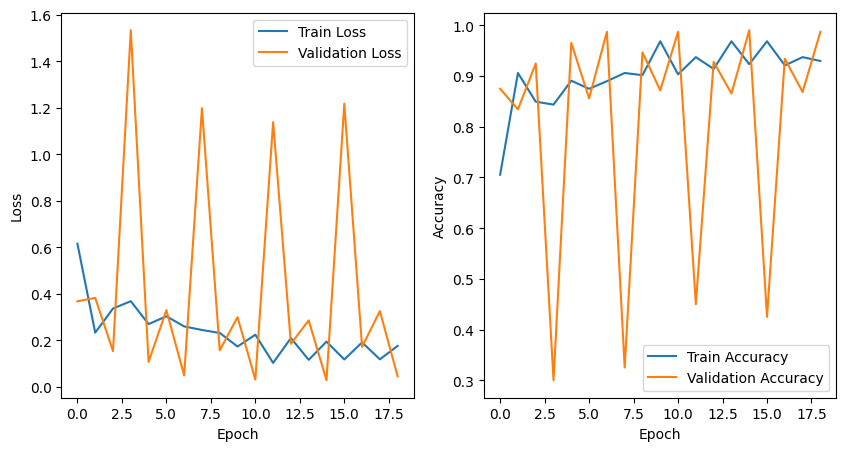

In [13]:
# Cargamos el modelo
model = load_model(model_path)
# Formatear el history para visualizarlo
formatted_history = prepare_history_data(history)
# Llamar a la función de plot
plot_training(formatted_history)

Observando la salida, de los gráficos superiores, tenemos una idea más clara de por qué paro el entrenamiento después de la época 19. En él se observa cómo después de alrededor de la época de entrenamiento 3, la accuracy de validación parece estancarse siguiendo el mismo patrón a partir de entonces sin producirse ninguna mejora significativa. Además, la función de pérdida (*loss*) de la validación mantenie de igual modo la misma tendencia a partir de ese punto, mientras que la de entrenamiento sigue disminuyendo constantemente a un ritmo considerable, implicando que el modelo sigue mejorando en la predicción de los datos de entrenamiento, pero no impactando a la validación tal y como hemos supuesto antes.

Así, aunque el modelo alcanza una precisión superior al 90% en el conjunto de entrenamiento, parece ocurrir lo mismo en el de validación, donde la precisión alcanza de igual manera más del 90% de precisión. Esto implica que parecen no existir claros indicios de sobreajuste a los datos del modelo. Sin embargo,ante la rara apariencia tan variables de las métricas de validación observadas en el gráfico, en el que aunque parecen seguir un patrón estable y quedarse estancadas, nos resulta extraño la tendencia abrupta de dichas métricas, se procede a tratar de implementar algunos métodos de regularización para ver si la tendencia mencionada disminuye y se logra suavizar en los notebooks posteriores esperando obtener resultados más estables durante la validación.

En este sentido, aunque parece haber un patrón de mejora continua en la precisión de entrenamiento, la pérdida de validación fluctúa, lo cual podría indicar problemas con la varianza de los datos o con la forma en que el modelo está interactuando con el conjunto de validación. No obstante, el alto nivel de precisión de validación sugiere que el modelo está funcionando bien a pesar de estas fluctuaciones en la pérdida. Esto puede ser un indicativo de que el modelo es capaz de generalizar adecuadamente a pesar de su complejidad creciente, aunque el patrón de la pérdida podría sugerir el inicio de un sobreajuste si la tendencia a disminuir en la pérdida de entrenamiento continuara mucho más allá de este punto.
Es decir, consideramos que estos resultados podrían deberse a algo circustancial, por lo que vamos a proceder a modificar la estructura de la red reutilizando los pesos del modelo base y explorar el *dropout* para tratar de ver si estos resultados obtenidos en este notebook se mantienen en el mismo camino o si efectivamente esta tendencia de las métricas de validación es algo circustancial.